In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm
from PIL import Image

In [2]:
class PokemonDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.csv_data = pd.read_csv(csv_file)
        self.image_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.csv_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.image_dir, f"{self.csv_data.iloc[idx, 0]}.png")  # Image path
        image = Image.open(img_name).convert("RGB")  # Open image
        
        image = self.transform(image)  # Apply transforms to image    
        Type1 = self.csv_data.iloc[idx, 1]  # Type 1 (numerical)
        Type2 = self.csv_data.iloc[idx, 2]  # Type 2 (numerical)

        return image, Type1, Type2

In [3]:
# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
# Setup Data
csv_file = '/kaggle/input/pokemon-images-and-types/pokemon.csv'
image_dir = '/kaggle/input/pokemon-images-and-types/images'

pokemon_data = pd.read_csv(csv_file)
print(pokemon_data.isnull().sum())

Name           0
Type1          0
Type2        404
Evolution    777
dtype: int64


In [11]:
# Fill type2 null values
pokemon_data.fillna({'Type2': 'Unknown'}, inplace=True)
print(pokemon_data.isnull().sum())

Name           0
Type1          0
Type2          0
Evolution    777
dtype: int64


In [12]:
# Get unique types for number of classes
unique_types1 = pokemon_data['Type1'].unique()
unique_types2 = pokemon_data['Type2'].unique()
all_unique_types = set(unique_types1).union(set(unique_types2))
num_classes = len(all_unique_types)

# LabelEncode types into numericals 
all_types = list(pokemon_data['Type1']) + list(pokemon_data['Type2'])
label_encoder = LabelEncoder()
label_encoder.fit(all_types)

pokemon_data['Type1'] = label_encoder.transform(pokemon_data['Type1'])
pokemon_data['Type2'] = label_encoder.transform(pokemon_data['Type2'])

processed_csv_file = '/kaggle/working/processed_pokemon.csv'
pokemon_data.to_csv(processed_csv_file, index=False)

# Create dataset and split it
dataset = PokemonDataset(processed_csv_file, image_dir, transform)
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, train_size=0.8, shuffle=True)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
class SimplePokemonClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SimplePokemonClassifier, self).__init__()
#         self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.base_model = timm.create_model('resnet18', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])  # Remove additional last layer
        
#         enet_out_size = 1280  # Output size of EfficientNet-B0's feature extractor.
        resnet_out_size = self.base_model.fc.in_features
        self.classifier_type1 = nn.Sequential(
#             nn.BatchNorm1d(enet_out_size),
            nn.BatchNorm1d(resnet_out_size),
            nn.Dropout(0.5),
#             nn.Linear(enet_out_size, num_classes)
            nn.Linear(resnet_out_size, num_classes)
        )
        
        self.classifier_type2 = nn.Sequential(
#             nn.BatchNorm1d(enet_out_size),
            nn.BatchNorm1d(resnet_out_size),
            nn.Dropout(0.5),
#             nn.Linear(enet_out_size, num_classes)
            nn.Linear(resnet_out_size, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        output_type1 = self.classifier_type1(x)
        output_type2 = self.classifier_type2(x)
        return output_type1, output_type2
    
model = SimplePokemonClassifier(num_classes=num_classes)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [14]:
# PYTORCH TRAINING LOOP

## Loss fn, optimer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epoch = 15
train_losses = []
train_accuracies_type1 = []
train_accuracies_type2 = []

def calculate_accuracy(output, target):
    _, preds = torch.max(output, 1)
    correct = (preds == target).sum().item()
    return correct / target.size(0)

# Training function
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    running_corrects_type1 = 0
    running_corrects_type2 = 0
    
    for images, labels_type1, labels_type2 in tqdm(train_loader, desc='Training Loop'):
        images = images.to(device)
        labels_type1 = labels_type1.to(device)
        labels_type2 = labels_type2.to(device)
        
        optimizer.zero_grad()
        outputs_type1, outputs_type2 = model(images)
        
        loss_type1 = criterion(outputs_type1, labels_type1)
        loss_type2 = criterion(outputs_type2, labels_type2)
        loss = loss_type1 + loss_type2
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        running_corrects_type1 += (outputs_type1.argmax(dim=1) == labels_type1).sum().item()
        running_corrects_type2 += (outputs_type2.argmax(dim=1) == labels_type2).sum().item()
        
    scheduler.step()
    
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy_type1 = running_corrects_type1 / len(train_loader.dataset)
    train_accuracy_type2 = running_corrects_type2 / len(train_loader.dataset)
    
    return train_loss, train_accuracy_type1, train_accuracy_type2

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects_type1 = 0
    running_corrects_type2 = 0
    
    with torch.no_grad():
        for images, labels_type1, labels_type2 in tqdm(test_loader, desc='Validation Loop'):
            images = images.to(device)
            labels_type1 = labels_type1.to(device)
            labels_type2 = labels_type2.to(device)
            
            outputs_type1, outputs_type2 = model(images)
            
            loss_type1 = criterion(outputs_type1, labels_type1)
            loss_type2 = criterion(outputs_type2, labels_type2)
            loss = loss_type1 + loss_type2
            
            running_loss += loss.item() * images.size(0)
            running_corrects_type1 += (outputs_type1.argmax(dim=1) == labels_type1).sum().item()
            running_corrects_type2 += (outputs_type2.argmax(dim=1) == labels_type2).sum().item()
    
    test_loss = running_loss / len(test_loader.dataset)
    test_accuracy_type1 = running_corrects_type1 / len(test_loader.dataset)
    test_accuracy_type2 = running_corrects_type2 / len(test_loader.dataset)
    
    return test_loss, test_accuracy_type1, test_accuracy_type2

# Loop
for epoch in range(num_epoch):
    # Train the model
    train_loss, train_accuracy_type1, train_accuracy_type2 = train(model, train_loader, criterion, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accuracies_type1.append(train_accuracy_type1)
    train_accuracies_type2.append(train_accuracy_type2)
    
    # Print epoch stats for training
    print(f"Epoch {epoch+1}/{num_epoch} - Train Loss: {train_loss:.4f}, Train Acc Type1: {train_accuracy_type1:.4f}, Train Acc Type2: {train_accuracy_type2:.4f}")

# Evaluate the model on the test set
test_loss, test_accuracy_type1, test_accuracy_type2 = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc Type1: {test_accuracy_type1:.4f}, Test Acc Type2: {test_accuracy_type2:.4f}")

Training Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 6.1950, Train Acc Type1: 0.0665, Train Acc Type2: 0.1005


Training Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 5.2026, Train Acc Type1: 0.2241, Train Acc Type2: 0.2813


Training Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 4.3585, Train Acc Type1: 0.3740, Train Acc Type2: 0.4359


Training Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 3.3710, Train Acc Type1: 0.5240, Train Acc Type2: 0.5425


Training Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 2.5128, Train Acc Type1: 0.6476, Train Acc Type2: 0.7218


Training Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 1.7748, Train Acc Type1: 0.8130, Train Acc Type2: 0.8037


Training Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 1.5863, Train Acc Type1: 0.8609, Train Acc Type2: 0.8702


Training Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 1.4479, Train Acc Type1: 0.8841, Train Acc Type2: 0.8717


Training Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 1.3149, Train Acc Type1: 0.8779, Train Acc Type2: 0.9011


Training Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 1.2282, Train Acc Type1: 0.9104, Train Acc Type2: 0.9196


Training Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 1.1872, Train Acc Type1: 0.9026, Train Acc Type2: 0.9104


Training Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 1.1556, Train Acc Type1: 0.9088, Train Acc Type2: 0.9212


Training Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 1.1463, Train Acc Type1: 0.9243, Train Acc Type2: 0.9104


Training Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 1.1196, Train Acc Type1: 0.9196, Train Acc Type2: 0.9243


Training Loop:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 1.1548, Train Acc Type1: 0.9165, Train Acc Type2: 0.9243


Validation Loop:   0%|          | 0/6 [00:00<?, ?it/s]

Test Loss: 4.6729, Test Acc Type1: 0.3272, Test Acc Type2: 0.4321


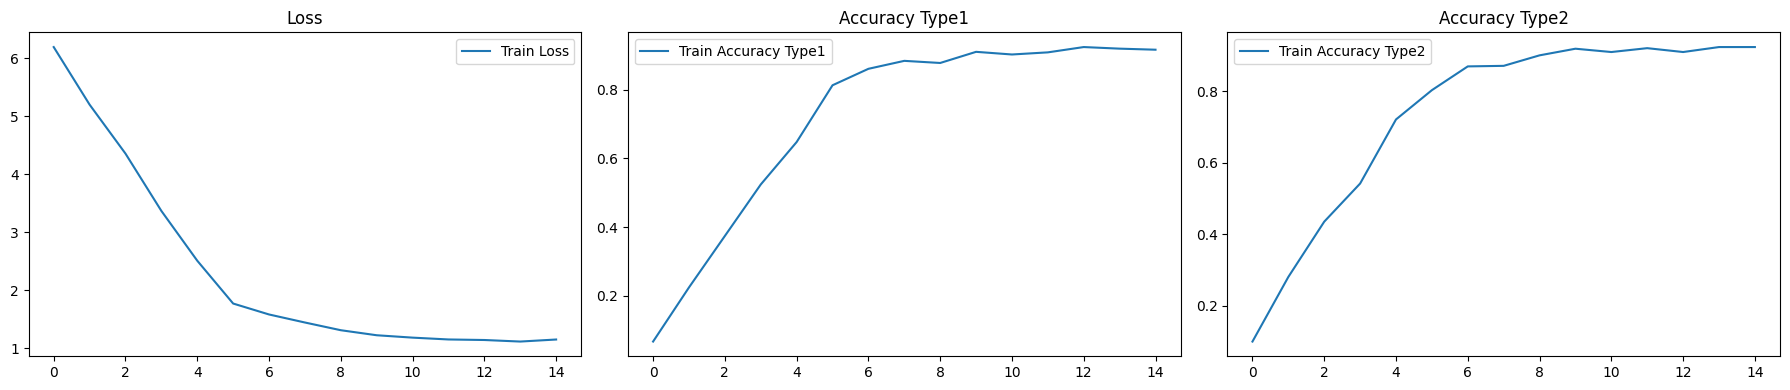

In [16]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# Loss
axs[0].plot(train_losses, label='Train Loss')
axs[0].legend()
axs[0].set_title('Loss')

# Accuracy for Type 1
axs[1].plot(train_accuracies_type1, label='Train Accuracy Type1')
axs[1].legend()
axs[1].set_title('Accuracy Type1')

# Accuracy for Type 2
axs[2].plot(train_accuracies_type2, label='Train Accuracy Type2')
axs[2].legend()
axs[2].set_title('Accuracy Type2')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Pokemon Summary

Possible overfitting. Tried to fix using L2 Regularization, Dropout, Batchnorm. I don't think it worked.  
Train accuracies: ~90%  
Test accuracies: ~30-45%